<a href="https://colab.research.google.com/github/Max-FM/IAA-Social-Distancing/blob/master/Differential_Imaging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Differential Imaging

**Warning:** This notebook will likely cause Google Colab to crash. It is advised to run the notebook locally, either by downloading and running through Jupyter or by connecting to a local runtime.

**Disclaimer:** Satellite images are not publicly available in the GitHub repository in order to avoid potential legal issues. The images used are available internally to other researchers at the University of Portsmouth [here](https://drive.google.com/drive/folders/1GGK6HksIM7jISqC71g0KpzSJnPjFkWO2?usp=sharing). Access is restricted to external persons and all external access requests will be denied. Should the user wish to acquire the images themselves, the corresponding shapefiles are publicly available in the repository.

###Import Files

In [1]:
import rasterio as rio
import rioxarray as riox

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

from glob import glob

###Define Filepaths

In [2]:
fdir = '/home/foxleym/Downloads'

filepaths = glob(f'{fdir}/Southsea2020_PSScene4Band_Explorer/files/*_SR_clip.tif')

###Create 4-Band Median Raster

In [3]:
blueList = []
greenList = []
redList = []
nirList = []

for i, file in enumerate(filepaths):
    blueList.append(riox.open_rasterio(file)[0,:,:])
    greenList.append(riox.open_rasterio(file)[1,:,:])
    redList.append(riox.open_rasterio(file)[2,:,:])
    nirList.append(riox.open_rasterio(file)[3,:,:])
    
blue_median = xr.concat(blueList, "t").median(dim="t")
green_median = xr.concat(greenList, "t").median(dim="t")
red_median = xr.concat(redList, "t").median(dim="t")
nir_median = xr.concat(nirList, "t").median(dim="t")

median_raster = xr.concat([blue_median, green_median, red_median, nir_median], dim='band')

del(blueList, greenList, redList, nirList, blue_median, green_median, red_median, nir_median)

median_raster.rio.to_raster(f'{fdir}/Southsea2020_PSScene4Band_Explorer/Southsea2020Median.tif')

###Obtain Median RBG Raster and Plot

([], <a list of 0 Text yticklabel objects>)

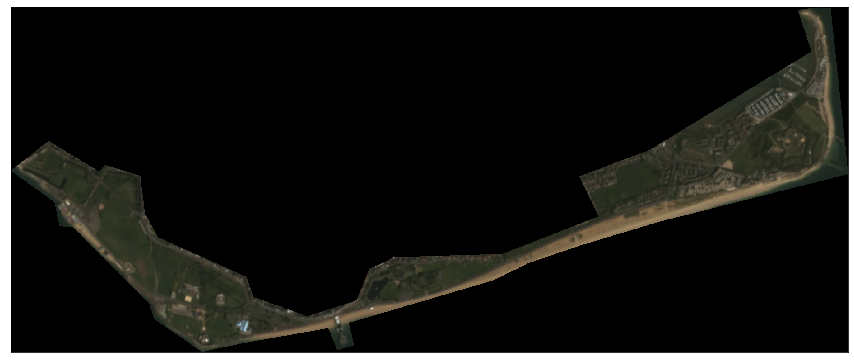

In [4]:
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

def make_composite(band_1, band_2, band_3):
    """Converts three raster bands into a composite image"""
    return normalize(np.dstack((band_1, band_2, band_3)))

b, g, r, nir = median_raster

rgb = make_composite(r, g, b)

plt.figure(figsize=(15,15))
plt.imshow(rgb)
plt.xticks([])
plt.yticks([])

###Perform Image Subtractions

In [5]:
subtractions = []

for f in filepaths:
    fname = f.split('/')[-1].split('.')[0]    
    
    raster = riox.open_rasterio(f)
    
    subtraction = raster - median_raster

    subtractions.append(subtraction)
    
    subtraction.rio.to_raster(f'{fdir}/Southsea2020_PSScene4Band_Explorer/files/{fname}_MEDDIFF.tif')

###Convert to RBG and Plot

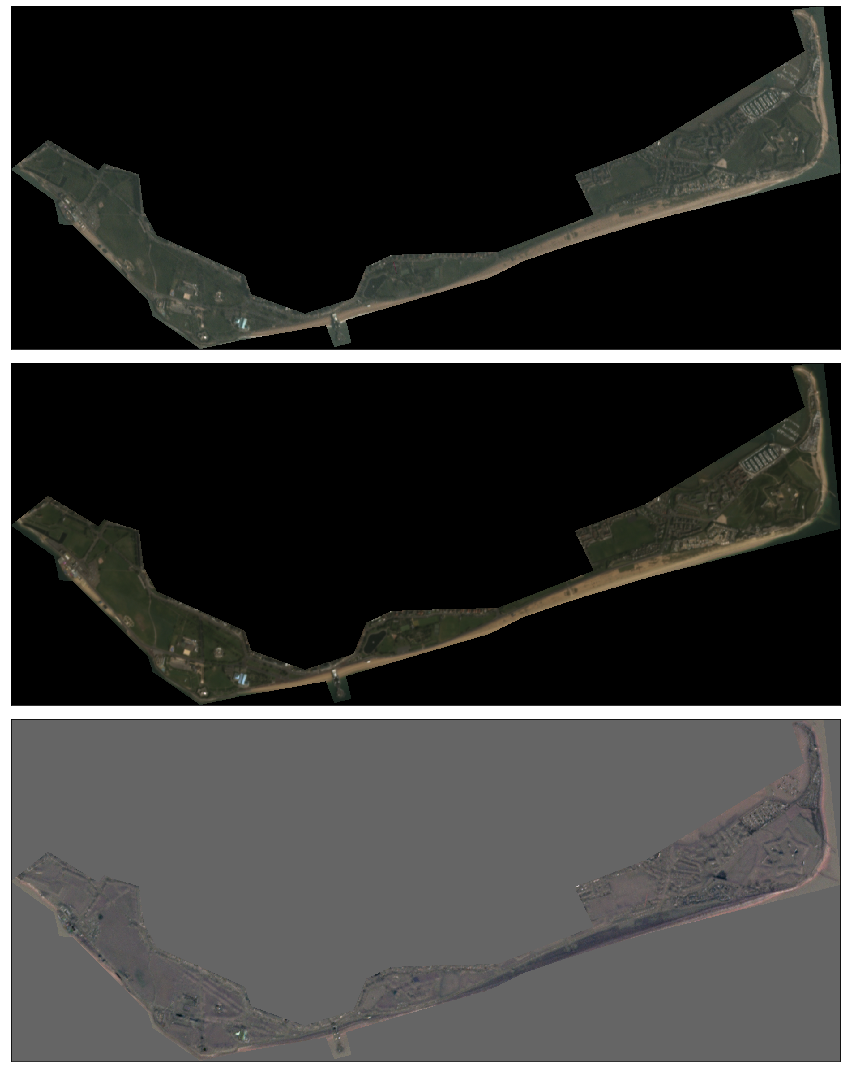

In [6]:
b_0, g_0, r_0, nir_0 = raster    
b_med, g_med, r_med, nir_med = median_raster
b_sub, g_sub, r_sub, nir_sub = subtractions[0]

rgb_0 = make_composite(r_0, g_0, b_0)
rgb_med = make_composite(r_med, g_med, b_med)
rgb_sub = make_composite(r_sub, g_sub, b_sub)

rgb_list = [rgb_0, rgb_med, rgb_sub]

fig, ax = plt.subplots(nrows = 3, figsize=(15,15))


for i, rgb in enumerate(rgb_list):
    ax[i].imshow(rgb)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
plt.tight_layout()